# code


In [ ]:
import pandas as pd
import chardet
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
!pip install modAL

from modAL.models import ActiveLearner
from modAL.uncertainty import uncertainty_sampling
from IPython import display

pd.read_csv("202209_YouBike2.0票證刷卡資料.csv",encoding = "utf-8")
with open('202209_YouBike2.0票證刷卡資料.csv', 'rb') as f:
    result = chardet.detect(f.read())

try:
    df = pd.read_csv('202209_YouBike2.0票證刷卡資料.csv', encoding=result['encoding'])
except UnicodeDecodeError:
    df = pd.read_csv('202209_YouBike2.0票證刷卡資料.csv', encoding='ISO-8859-1')
df['rent_time'] = pd.to_datetime(df['rent_time'])
df['return_time'] = pd.to_datetime(df['return_time'])
df['rent'] = pd.to_timedelta(df['rent'])
df['infodate'] = pd.to_datetime(df['infodate'])
df['hour'] = df['rent_time'].dt.hour
df['weekday'] = df['rent_time'].dt.weekday
df['is_weekend'] = (df['weekday'] >= 5).astype(int)
hourly_counts = df.groupby(['rent_station', 'hour'])['rent'].count().reset_index(name='hourly_count')
def calculate_no_bike(df, threshold=5):
    
    avg_hourly_counts = df.groupby(['rent_station', 'hour'])['rent'].count().mean(level=0)
    
    no_bike = df['rent_station'].map(avg_hourly_counts) < threshold
    
    return no_bike

hourly_counts['no_bike'] = calculate_no_bike(df)
hourly_counts['no_bike'] = hourly_counts['no_bike'].astype(bool)

rent_station_encoded = pd.get_dummies(hourly_counts['rent_station'], prefix='rent_station')
hourly_counts_encoded = pd.concat([hourly_counts.drop(columns=['rent_station']), rent_station_encoded], axis=1)

hourly_counts_encoded = hourly_counts_encoded.fillna(0)

def calculate_no_station(df, threshold=5):
    avg_hourly_return_counts = df.groupby(['return_station', 'hour_return'])['rent'].count().mean(level=0)
    no_station = df['return_station'].map(avg_hourly_return_counts) >= threshold
    return no_station

df['hour_return'] = df['return_time'].dt.hour
hourly_counts_return = df.groupby(['return_station', 'hour_return'])['rent'].count().reset_index(name='hourly_return_count')

hourly_counts_return['no_station'] = calculate_no_station(df)
hourly_counts_return['no_station'] = hourly_counts_return['no_station'].astype(bool)

return_station_encoded = pd.get_dummies(hourly_counts_return['return_station'], prefix='return_station')
hourly_counts_encoded_return = pd.concat([hourly_counts_return.drop(columns=['return_station']), return_station_encoded], axis=1)

hourly_counts_encoded_return = hourly_counts_encoded_return.fillna(0)

X_train_no_bike, X_test_no_bike, y_train_no_bike, y_test_no_bike = train_test_split(hourly_counts_encoded.drop(columns=['no_bike']), hourly_counts_encoded['no_bike'], test_size=0.3, random_state=42)

clf_no_bike = RandomForestClassifier(n_estimators=100, random_state=42)
clf_no_bike.fit(X_train_no_bike, y_train_no_bike)
y_pred_no_bike = clf_no_bike.predict(X_test_no_bike)
accuracy_no_bike = accuracy_score(y_test_no_bike, y_pred_no_bike)
print("No Bike Accuracy:", accuracy_no_bike)

X_train_no_station, X_test_no_station, y_train_no_station, y_test_no_station = train_test_split(hourly_counts_encoded_return.drop(columns=['no_station']), hourly_counts_encoded_return['no_station'], test_size=0.3, random_state=42)

clf_no_station = RandomForestClassifier(n_estimators=100, random_state=42)
clf_no_station.fit(X_train_no_station, y_train_no_station)
y_pred_no_station = clf_no_station.predict(X_test_no_station)
accuracy_no_station = accuracy_score(y_test_no_station, y_pred_no_station)
print("No Station Accuracy:", accuracy_no_station)

base_clf = RandomForestClassifier(n_estimators=100, random_state=42)

learner_b = ActiveLearner(
    estimator=base_clf,
    X_training=X_train_no_bike.to_numpy(),
    y_training=y_train_no_bike.to_numpy(),
    query_strategy=uncertainty_sampling
)

X_pool_b, y_pool_b = X_test_no_bike.to_numpy(), y_test_no_bike.to_numpy()
accuracy_scores = [learner_b.score(X_test_no_bike, y_test_no_bike)]

n_queries = 30
for i in range(n_queries):
    display.clear_output(wait=True)
    query_idx, query_inst = learner_b.query(X_pool_b)
    
    y_new = y_pool_b[query_idx].reshape(1, )
    learner_b.teach(query_inst.reshape(1, -1), y_new)
    
    X_pool_b, y_pool_b = np.delete(X_pool_b, query_idx, axis=0), np.delete(y_pool_b, query_idx, axis=0)
    
    accuracy_scores.append(learner_b.score(X_test_no_bike, y_test_no_bike))

    plt.figure(figsize=(10, 5))
    plt.plot(range(i + 2), accuracy_scores)
    plt.scatter(range(i + 2), accuracy_scores)
    plt.xlabel('Number of Queries')
    plt.ylabel('Accuracy')
    plt.title('Accuracy of the Model')
    display.display(plt.gcf())
    plt.close('all')
    print(accuracy_scores)

average_accuracy_b = np.mean(accuracy_scores)
print("Average accuracy:", average_accuracy_b)

learner_s = ActiveLearner(
    estimator=base_clf,
    X_training=X_train_no_station.to_numpy(),
    y_training=y_train_no_station.to_numpy(),
    query_strategy=uncertainty_sampling
)

X_pool_s, y_pool_s = X_test_no_station.to_numpy(), y_test_no_station.to_numpy()
accuracy_scores = [learner_s.score(X_test_no_station, y_test_no_station)]

n_queries = 30
for i in range(n_queries):
    display.clear_output(wait=True)
    query_idx, query_inst = learner_s.query(X_pool_s)
    
    y_new_s = y_pool_s[query_idx].reshape(1, )
    learner_s.teach(query_inst.reshape(1, -1), y_new_s)
    
    X_pool_s, y_pool_s = np.delete(X_pool_s, query_idx, axis=0), np.delete(y_pool_s, query_idx, axis=0)
    
    accuracy_scores.append(learner_s.score(X_test_no_station, y_test_no_station))

    plt.figure(figsize=(10, 5))
    plt.plot(range(i + 2), accuracy_scores)
    plt.scatter(range(i + 2), accuracy_scores)
    plt.xlabel('Number of Queries')
    plt.ylabel('Accuracy')
    plt.title('Accuracy of the Model')
    display.display(plt.gcf())
    plt.close('all')
    print(accuracy_scores)

average_accuracy_s = np.mean(accuracy_scores)
print("Average accuracy:", average_accuracy_s)

In [ ]:
station_name_input = input("請輸入租賃站名稱：")
current_hour_input = int(input("請輸入當前時間的小時數（24小時制）："))
current_weekday_put = int(input("請輸入當前的星期幾，以數字表示（例如星期一為1，星期二為2）："))
current_bikes_input = int(input("請輸入該租賃站當前可用的單車數量："))

def predict_no_bike_no_station(station_name, current_hour, current_weekday, current_bikes,learner_no_bike, learner_no_station, rent_station_columns, return_station_columns ):
    rent_station_encoded = encode_rent_station(station_name, rent_station_columns)
    return_station_encoded = encode_return_station(station_name, return_station_columns)

    X_no_bike = pd.DataFrame({
        'hour': [current_hour],
        'weekday': [current_weekday],
        'is_weekend': [int(current_weekday >= 5)],
        **dict(zip(rent_station_columns, rent_station_encoded))
    })

    X_no_station = pd.DataFrame({
        'hour': [current_hour],
        'weekday': [current_weekday],
        'is_weekend': [int(current_weekday >= 5)],
        **dict(zip(return_station_columns, return_station_encoded))
    })

    no_bike_pred = learner_no_bike.predict(X_no_bike)
    no_station_pred = learner_no_station.predict(X_no_station)

    result = {
        'station_name': station_name,
        'no_bike': "有" if no_bike_pred[0] else "無",
        'no_station': "有" if no_station_pred[0] else "無"
    }

    return result

def encode_rent_station(station_name, rent_station_columns):
    return [1 if col == f"rent_station_{station_name}" else 0 for col in rent_station_columns]

def encode_return_station(station_name, return_station_columns):
    return [1 if col == f"return_station_{station_name}" else 0 for col in return_station_columns]

def predict_from_input(station_name_input, current_hour_input, current_weekday_input, current_bikes_input):
    result = predict_no_bike_no_station(station_name_input, current_hour_input, current_weekday_input, current_bikes_input, learner_b, learner_s, X_train_no_bike.columns[3:], X_train_no_station.columns[3:])
    return result

result = predict_from_input(station_name_input, current_hour_input, current_weekday_put, current_bikes_input)
print(result)


#MID PROJECT


## **1. 引入library跟安裝modAl**




In [ ]:
import pandas as pd
import chardet
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
!pip install modAL

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from modAL.models import ActiveLearner
from modAL.uncertainty import uncertainty_sampling
from IPython import display
from sklearn.compose import ColumnTransformer


## **2. 資料集處理**

打開 CSV 檔案並檢測其編碼方式



---


嘗試以檢測到的編碼方式讀取 CSV 檔案，若失敗則以 ISO-8859-1 編碼讀取

In [ ]:
pd.read_csv("202209_YouBike2.0票證刷卡資料.csv",encoding = "utf-8")

,rent_time,rent_station,return_time,return_station,rent,infodate
0,2022-09-30 21:00:00,捷運大湖公園站(2號出口),2022-09-30 21:00:00,安湖三號公園,00:12:27,2022-09-30
1,2022-09-30 21:00:00,捷運大湖公園站(2號出口),2022-09-30 21:00:00,康寧公園(北側),00:12:56,2022-09-30
2,2022-09-30 21:00:00,捷運大湖公園站(2號出口),2022-09-30 21:00:00,大湖國小,00:11:10,2022-09-30
3,2022-09-30 21:00:00,捷運大湖公園站(2號出口),2022-09-30 21:00:00,康樂綠地,00:29:07,2022-09-30
4,2022-09-30 22:00:00,捷運大湖公園站(2號出口),2022-09-30 22:00:00,大湖國小,00:03:55,2022-09-30
...,...,...,...,...,...,...
108282,2022-09-05 16:00:00,關渡自然公園,2022-09-05 17:00:00,關渡醫院,00:55:40,2022-09-05
108283,2022-09-05 08:00:00,關渡醫院,2022-09-05 08:00:00,捷運關渡站(1號出口),00:03:07,2022-09-05
108284,2022-09-05 20:00:00,關渡醫院,2022-09-05 20:00:00,捷運關渡站(1號出口),00:05:17,2022-09-05
108285,2022-09-05 22:00:00,捷運忠義站(1號出口),2022-09-05 22:00:00,捷運忠義站(1號出口),00:09:11,2022-09-05


In [ ]:
with open('202209_YouBike2.0票證刷卡資料.csv', 'rb') as f:
    result = chardet.detect(f.read())

try:
    df = pd.read_csv('202209_YouBike2.0票證刷卡資料.csv', encoding=result['encoding'])
except UnicodeDecodeError:
    df = pd.read_csv('202209_YouBike2.0票證刷卡資料.csv', encoding='ISO-8859-1')



1.   將 rent_time、return_time、rent 和 infodate 欄位轉換為對應的時間格式

---


2.   新增 hour 和 weekday 欄位，分別表示租借時間的小時數和星期幾



---
3. 新增 is_weekend 欄位，表示該時間是否為週末

---
4.  對每個租借站和小時統計租借次數





In [ ]:
df['rent_time'] = pd.to_datetime(df['rent_time'])
df['return_time'] = pd.to_datetime(df['return_time'])
df['rent'] = pd.to_timedelta(df['rent'])
df['infodate'] = pd.to_datetime(df['infodate'])
df['hour'] = df['rent_time'].dt.hour
df['weekday'] = df['rent_time'].dt.weekday
df['is_weekend'] = (df['weekday'] >= 5).astype(int)
hourly_counts = df.groupby(['rent_station', 'hour'])['rent'].count().reset_index(name='hourly_count')

In [ ]:
df

,rent_time,rent_station,return_time,return_station,rent,infodate,hour,weekday,is_weekend
0,2022-09-30 21:00:00,æ·éå¤§æ¹å ¬åç«(2èåºå£),2022-09-30 21:00:00,å®æ¹ä¸èå ¬å,0 days 00:12:27,2022-09-30,21,4,0
1,2022-09-30 21:00:00,æ·éå¤§æ¹å ¬åç«(2èåºå£),2022-09-30 21:00:00,åº·å¯§å ¬å(åå´),0 days 00:12:56,2022-09-30,21,4,0
2,2022-09-30 21:00:00,æ·éå¤§æ¹å ¬åç«(2èåºå£),2022-09-30 21:00:00,å¤§æ¹åå°,0 days 00:11:10,2022-09-30,21,4,0
3,2022-09-30 21:00:00,æ·éå¤§æ¹å ¬åç«(2èåºå£),2022-09-30 21:00:00,åº·æ¨ç¶ å°,0 days 00:29:07,2022-09-30,21,4,0
4,2022-09-30 22:00:00,æ·éå¤§æ¹å ¬åç«(2èåºå£),2022-09-30 22:00:00,å¤§æ¹åå°,0 days 00:03:55,2022-09-30,22,4,0
...,...,...,...,...,...,...,...,...,...
138226,2022-09-30 16:00:00,èºå¤§ç¦®è³¢æ¨æ±åå´,2022-09-30 17:00:00,èºå¤§æ°é«è²é¤¨æ±åå´,0 days 00:09:24,2022-09-30,16,4,0
138227,2022-09-30 16:00:00,èºå¤§ç¦®è³¢æ¨æ±åå´,2022-09-30 17:00:00,èºå¤§å¤§ä¸å¥³èåå´,0 days 00:45:51,2022-09-30,16,4,0
138228,2022-09-30 17:00:00,èºå¤§ç¦®è³¢æ¨æ±åå´,2022-09-30 17:00:00,æ·éå¤äº­ç«(7èåºå£),0 days 00:20:10,2022-09-30,17,4,0
138229,2022-09-30 16:00:00,èºå¤§ç¦®è³¢æ¨æ±åå´,2022-09-30 17:00:00,èºå¤§ç¦®è³¢æ¨æ±åå´,0 days 00:36:41,2022-09-30,16,4,0


## **3. 定義沒空站點與沒車**

### no_bike(缺車)

定義 calculate_no_bike 函數，計算每個租借站在不同小時的平均租借次數，並判斷是否低於閾值(5)


---

因為我們沒有辦法得知各個時段各站點是否有車，於是我們用我們已知道的資料，也就是每一台車是從哪站租借，假如某一站點一小時內租借的車輛小於5台，我們就將該段時間視為沒有車可借

In [ ]:
def calculate_no_bike(df, threshold=5):
    
    avg_hourly_counts = df.groupby(['rent_station', 'hour'])['rent'].count().mean(level=0)
    
    no_bike = df['rent_station'].map(avg_hourly_counts) < threshold
    
    return no_bike

1. 計算每個小時段租借站是否缺車

---

2. 將 no_bike 欄位轉換為bool類型

---

3. 對 rent_station 進行編碼，並將其與原數據表合併

---
4. 用 0 填充hourly_counts_encoded的缺失值


In [ ]:
hourly_counts['no_bike'] = calculate_no_bike(df)
hourly_counts['no_bike'] = hourly_counts['no_bike'].astype(bool)

rent_station_encoded = pd.get_dummies(hourly_counts['rent_station'], prefix='rent_station')
hourly_counts_encoded = pd.concat([hourly_counts.drop(columns=['rent_station']), rent_station_encoded], axis=1)

hourly_counts_encoded = hourly_counts_encoded.fillna(0)

<ipython-input-16-3a0eb803d0d4>:3: FutureWarning: Using the level keyword in DataFrame and Series aggregations is deprecated and will be removed in a future version. Use groupby instead. df.median(level=1) should use df.groupby(level=1).median().
  avg_hourly_counts = df.groupby(['rent_station', 'hour'])['rent'].count().mean(level=0)


### no_station(滿站)

定義 calculate_no_station函數，計算每個租借站在不同小時的平均租借次數，並判斷是否低於閾值(3)


---

因為我們沒有辦法得知各個時段各站點是否有空位停車，於是我們用我們已知道的資料，也就是每一台車是到哪站租還，假如某一站點一小時內還車的車輛數小於3台，我們就將該段時間視為沒有空位可還

In [ ]:
def calculate_no_station(df, threshold=3):
    avg_hourly_return_counts = df.groupby(['return_station', 'hour_return'])['rent'].count().mean(level=0)
    no_station = df['return_station'].map(avg_hourly_return_counts) >= threshold
    return no_station

df['hour_return'] = df['return_time'].dt.hour
hourly_counts_return = df.groupby(['return_station', 'hour_return'])['rent'].count().reset_index(name='hourly_return_count')


1. 計算每個小時段租借站是否滿站

---

2. 將 no_station 欄位轉換為bool類型

---

3. 對 return_station 進行編碼，並將其與原數據表合併

---
4. 用 0 填充hourly_counts_encoded_return的缺失值


In [ ]:
hourly_counts_return['no_station'] = calculate_no_station(df)
hourly_counts_return['no_station'] = hourly_counts_return['no_station'].astype(bool)

return_station_encoded = pd.get_dummies(hourly_counts_return['return_station'], prefix='return_station')
hourly_counts_encoded_return = pd.concat([hourly_counts_return.drop(columns=['return_station']), return_station_encoded], axis=1)

hourly_counts_encoded_return = hourly_counts_encoded_return.fillna(0)


<ipython-input-18-109ff5081d48>:2: FutureWarning: Using the level keyword in DataFrame and Series aggregations is deprecated and will be removed in a future version. Use groupby instead. df.median(level=1) should use df.groupby(level=1).median().
  avg_hourly_return_counts = df.groupby(['return_station', 'hour_return'])['rent'].count().mean(level=0)


## **4.隨機森林分類器，計算預測準確率**

創建隨機森林分類器（缺車）,進行預測，並且計算準確率

In [ ]:
X_train_no_bike, X_test_no_bike, y_train_no_bike, y_test_no_bike = train_test_split(hourly_counts_encoded.drop(columns=['no_bike']), hourly_counts_encoded['no_bike'], test_size=0.3, random_state=42)

clf_no_bike = RandomForestClassifier(n_estimators=100, random_state=42)
clf_no_bike.fit(X_train_no_bike, y_train_no_bike)
y_pred_no_bike = clf_no_bike.predict(X_test_no_bike)
accuracy_no_bike = accuracy_score(y_test_no_bike, y_pred_no_bike)
print("No Bike Accuracy:", accuracy_no_bike)


No Bike Accuracy: 0.9907183961388528


創建隨機森林分類器（滿站）,進行預測，並且計算準確率

In [ ]:
X_train_no_station, X_test_no_station, y_train_no_station, y_test_no_station = train_test_split(hourly_counts_encoded_return.drop(columns=['no_station']), hourly_counts_encoded_return['no_station'], test_size=0.3, random_state=42)

clf_no_station = RandomForestClassifier(n_estimators=100, random_state=42)
clf_no_station.fit(X_train_no_station, y_train_no_station)
y_pred_no_station = clf_no_station.predict(X_test_no_station)
accuracy_no_station = accuracy_score(y_test_no_station, y_pred_no_station)
print("No Station Accuracy:", accuracy_no_station)

No Station Accuracy: 0.856610222153177


## **5. 訓練模型**

創建基於隨機森林的基學習器

In [ ]:
base_clf = RandomForestClassifier(n_estimators=100, random_state=42)

### 空車情況下

使用 ActiveLearner 創建主動學習器（缺車）

In [ ]:
learner_b = ActiveLearner(
    estimator=base_clf,
    X_training=X_train_no_bike.to_numpy(),
    y_training=y_train_no_bike.to_numpy(),
    query_strategy=uncertainty_sampling
)

初始化測試集（缺車)與準確率

In [ ]:
X_pool_b, y_pool_b = X_test_no_bike.to_numpy(), y_test_no_bike.to_numpy()
accuracy_scores = [learner_b.score(X_test_no_bike, y_test_no_bike)]

/usr/local/lib/python3.9/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


反覆30次並且將每次的準確率畫成折線圖，在最後算出準確率平均

/usr/local/lib/python3.9/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


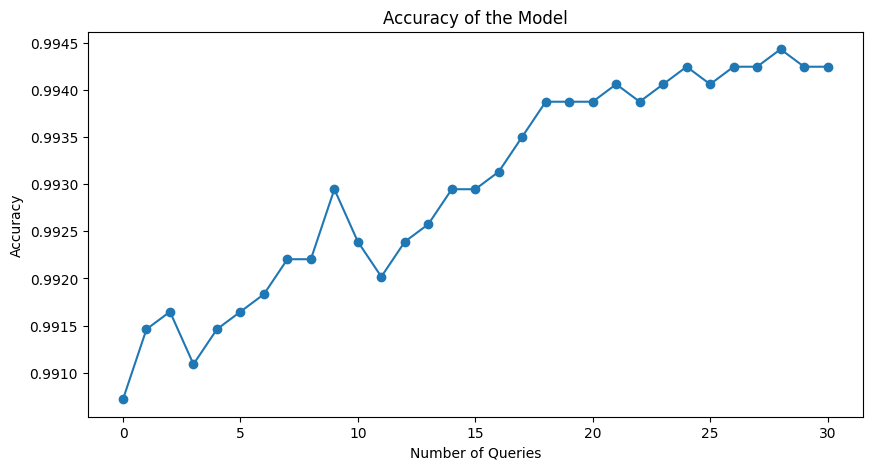

[0.9907183961388528, 0.9914609244477446, 0.9916465565249675, 0.9910896602932987, 0.9914609244477446, 0.9916465565249675, 0.9918321886021905, 0.9922034527566364, 0.9922034527566364, 0.9929459810655281, 0.9923890848338592, 0.9920178206794134, 0.9923890848338592, 0.9925747169110822, 0.9929459810655281, 0.9929459810655281, 0.9931316131427511, 0.993502877297197, 0.9938741414516429, 0.9938741414516429, 0.9938741414516429, 0.9940597735288658, 0.9938741414516429, 0.9940597735288658, 0.9942454056060888, 0.9940597735288658, 0.9942454056060888, 0.9942454056060888, 0.9944310376833116, 0.9942454056060888, 0.9942454056060888]
Average accuracy: 0.9929819098546683


In [ ]:
n_queries = 30
for i in range(n_queries):
    display.clear_output(wait=True)
    query_idx, query_inst = learner_b.query(X_pool_b)
    
    y_new = y_pool_b[query_idx].reshape(1, )
    learner_b.teach(query_inst.reshape(1, -1), y_new)
    
    X_pool_b, y_pool_b = np.delete(X_pool_b, query_idx, axis=0), np.delete(y_pool_b, query_idx, axis=0)
    
    accuracy_scores.append(learner_b.score(X_test_no_bike, y_test_no_bike))

    plt.figure(figsize=(10, 5))
    plt.plot(range(i + 2), accuracy_scores)
    plt.scatter(range(i + 2), accuracy_scores)
    plt.xlabel('Number of Queries')
    plt.ylabel('Accuracy')
    plt.title('Accuracy of the Model')
    display.display(plt.gcf())
    plt.close('all')
    print(accuracy_scores)

average_accuracy_b = np.mean(accuracy_scores)
print("Average accuracy:", average_accuracy_b)

### 滿站情況下

使用 ActiveLearner 創建主動學習器（滿站）

In [ ]:
learner_s = ActiveLearner(
    estimator=base_clf,
    X_training=X_train_no_station.to_numpy(),
    y_training=y_train_no_station.to_numpy(),
    query_strategy=uncertainty_sampling
)

初始化測試集（滿站) 與 準確率

In [ ]:
X_pool_s, y_pool_s = X_test_no_station.to_numpy(), y_test_no_station.to_numpy()
accuracy_scores = [learner_s.score(X_test_no_station, y_test_no_station)]

/usr/local/lib/python3.9/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


反覆30次並且將每次的準確率畫成折線圖，在最後算出準確率平均

/usr/local/lib/python3.9/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


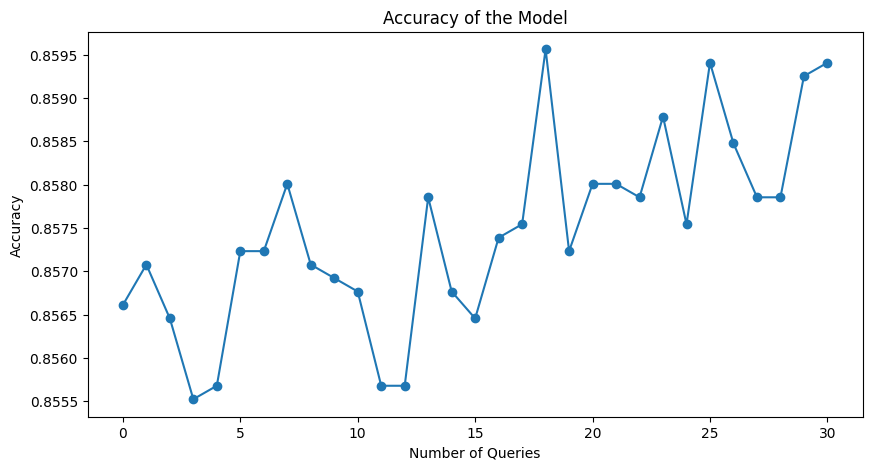

[0.856610222153177, 0.8570762777691471, 0.8564548702811869, 0.8555227590492466, 0.8556781109212366, 0.8572316296411372, 0.8572316296411372, 0.8580083890010874, 0.8570762777691471, 0.8569209258971571, 0.856765574025167, 0.8556781109212366, 0.8556781109212366, 0.8578530371290974, 0.856765574025167, 0.8564548702811869, 0.8573869815131272, 0.8575423333851173, 0.8595619077209881, 0.8572316296411372, 0.8580083890010874, 0.8580083890010874, 0.8578530371290974, 0.8587851483610377, 0.8575423333851173, 0.8594065558489979, 0.8584744446170577, 0.8578530371290974, 0.8578530371290974, 0.8592512039770079, 0.8594065558489979]
Average accuracy: 0.8574571404230583


In [ ]:
n_queries = 30
for i in range(n_queries):
    display.clear_output(wait=True)
    query_idx, query_inst = learner_s.query(X_pool_s)
    
    y_new_s = y_pool_s[query_idx].reshape(1, )
    learner_s.teach(query_inst.reshape(1, -1), y_new_s)
    
    X_pool_s, y_pool_s = np.delete(X_pool_s, query_idx, axis=0), np.delete(y_pool_s, query_idx, axis=0)
    
    accuracy_scores.append(learner_s.score(X_test_no_station, y_test_no_station))

    plt.figure(figsize=(10, 5))
    plt.plot(range(i + 2), accuracy_scores)
    plt.scatter(range(i + 2), accuracy_scores)
    plt.xlabel('Number of Queries')
    plt.ylabel('Accuracy')
    plt.title('Accuracy of the Model')
    display.display(plt.gcf())
    plt.close('all')
    print(accuracy_scores)

average_accuracy_s = np.mean(accuracy_scores)
print("Average accuracy:", average_accuracy_s)

## **6.預測系統**



In [ ]:
station_name_input = input("請輸入租賃站名稱：")
current_hour_input = int(input("請輸入當前時間的小時數（24小時制）："))
current_weekday_input = int(input("請輸入當前的星期幾，以數字表示（例如星期一為1，星期二為2）："))
current_bikes_input = int(input("請輸入該租賃站當前可用的單車數量："))

請輸入租賃站名稱：捷運忠義站(1號出口)
請輸入當前時間的小時數（24小時制）：2
請輸入當前的星期幾，以數字表示（例如星期一為1，星期二為2）：2
請輸入該租賃站當前可用的單車數量：1


In [ ]:
def get_rent_station_encoding(station_name, rent_station_columns):
    rent_station_encoding = np.zeros(len(rent_station_columns))
    rent_station_column = f"rent_station_{station_name}"
    if rent_station_column in rent_station_columns:
        index = rent_station_columns.index(rent_station_column)
        rent_station_encoding[index] = 1
    return rent_station_encoding

all_rent_stations_columns = list(pd.get_dummies(df['rent_station'], prefix='rent_station').columns)
all_return_stations_columns = list(pd.get_dummies(df['return_station'], prefix='return_station').columns)

rent_station_encoding_no_bike = get_rent_station_encoding(station_name_input, all_rent_stations_columns)
rent_station_encoding_no_station = get_rent_station_encoding(station_name_input, all_return_stations_columns)

is_weekend = 1 if current_weekday_input >= 5 else 0

feature_vector_no_bike = np.hstack(([current_hour_input, is_weekend], rent_station_encoding_no_bike))
feature_vector_no_station = np.hstack(([current_hour_input, is_weekend], rent_station_encoding_no_station))

no_bike_prediction = clf_no_bike.predict(feature_vector_no_bike.reshape(1, -1))
no_station_prediction = clf_no_station.predict(feature_vector_no_station.reshape(1, -1))



/usr/local/lib/python3.9/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


In [ ]:
no_bike_prediction = True
no_station_prediction = False

rent_message = "應該有足夠的單車可租。" if not no_bike_prediction else "可能沒有足夠的單車可租。"
return_message = "應該有足夠的停車位可歸還。" if not no_station_prediction else "可能會出現沒有停車位可歸還。"
current_bikes_message = f"目前 {station_name_input} 站有 {current_bikes_input} 輛單車。"

output_message = f"在 {station_name_input} 站，星期 {current_weekday_input} 的 {current_hour_input} 點，{rent_message} {return_message} {current_bikes_message}"

print(output_message)


在 捷運忠義站(1號出口) 站，星期 2 的 2 點，可能沒有足夠的單車可租。 應該有足夠的停車位可歸還。 目前 捷運忠義站(1號出口) 站有 1 輛單車。
